In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import lightgbm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [2]:
FEATURES_CSVS_PATH = "features_csvs/"
CATEGORIA_ACTUAL = "nivel_desemp_matematica"
PONDERADOR_ACTUAL = "ponderador_matematica"
CATEGORIA_NIVEL = "matematica"
CATEGORIA_LABEL = "matemática"

In [3]:
train = pd.read_csv(FEATURES_CSVS_PATH+"train_%s.csv" % CATEGORIA_NIVEL)
test = pd.read_csv(FEATURES_CSVS_PATH+"test_%s.csv" % CATEGORIA_NIVEL)

In [4]:
X_columns = [c for c in train.columns if c not in ['alumne_id', PONDERADOR_ACTUAL, CATEGORIA_ACTUAL, 'nivel']]
Y_columns = CATEGORIA_ACTUAL

In [5]:
y_lb = LabelEncoder()

In [6]:
import unidecode
X_train = train[X_columns]
Y_train = y_lb.fit_transform(train[Y_columns])
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_train.columns = [unidecode.unidecode(x) for x in X_train.columns]

In [7]:
import unidecode
X_test = test[X_columns]
Y_test = y_lb.transform(test[Y_columns])
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
X_test.columns = [unidecode.unidecode(x) for x in X_test.columns]

In [8]:
X_valid = X_test[:23000]
Y_valid = Y_test[:23000]

X_test = X_test[23000:]
Y_test = Y_test[23000:]

In [9]:
params = {'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'num_classes': 4,
    'feature_fraction':0.9,
    'max_depth':20}

In [10]:
d_train = lightgbm.Dataset(X_train, Y_train)

In [11]:
d_valid = lightgbm.Dataset(X_valid, Y_valid)

In [12]:
bst = lightgbm.train(params, d_train, 5000, verbose_eval=50, valid_sets=[d_valid])

[50]	valid_0's multi_logloss: 1.2847
[100]	valid_0's multi_logloss: 1.25662
[150]	valid_0's multi_logloss: 1.23985
[200]	valid_0's multi_logloss: 1.229
[250]	valid_0's multi_logloss: 1.22235
[300]	valid_0's multi_logloss: 1.21741
[350]	valid_0's multi_logloss: 1.21371
[400]	valid_0's multi_logloss: 1.21065
[450]	valid_0's multi_logloss: 1.20805
[500]	valid_0's multi_logloss: 1.20587
[550]	valid_0's multi_logloss: 1.20402
[600]	valid_0's multi_logloss: 1.20246
[650]	valid_0's multi_logloss: 1.20119
[700]	valid_0's multi_logloss: 1.19996
[750]	valid_0's multi_logloss: 1.19887
[800]	valid_0's multi_logloss: 1.19799
[850]	valid_0's multi_logloss: 1.19716
[900]	valid_0's multi_logloss: 1.1966
[950]	valid_0's multi_logloss: 1.19606
[1000]	valid_0's multi_logloss: 1.1956
[1050]	valid_0's multi_logloss: 1.19515
[1100]	valid_0's multi_logloss: 1.19479
[1150]	valid_0's multi_logloss: 1.19449
[1200]	valid_0's multi_logloss: 1.19415
[1250]	valid_0's multi_logloss: 1.19382
[1300]	valid_0's multi_lo

In [13]:
preds = bst.predict(X_test)

In [14]:
print(classification_report(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds])))

                       precision    recall  f1-score   support

             avanzado       0.51      0.18      0.26     25719
               basico       0.36      0.08      0.13     53784
por_debajo_del_basico       0.47      0.57      0.52     56083
        satisfactorio       0.43      0.71      0.54     73239

             accuracy                           0.45    208825
            macro avg       0.44      0.38      0.36    208825
         weighted avg       0.44      0.45      0.39    208825



In [15]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3]), array([25719, 53784, 56083, 73239]))

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
cm = confusion_matrix(y_lb.inverse_transform(Y_test), y_lb.inverse_transform([np.argmax(p) for p in preds]), 
                      labels=["por_debajo_del_basico", "basico", "satisfactorio", "avanzado"])

In [18]:
cm_relative = cm/cm.astype(np.float).sum(axis=0)

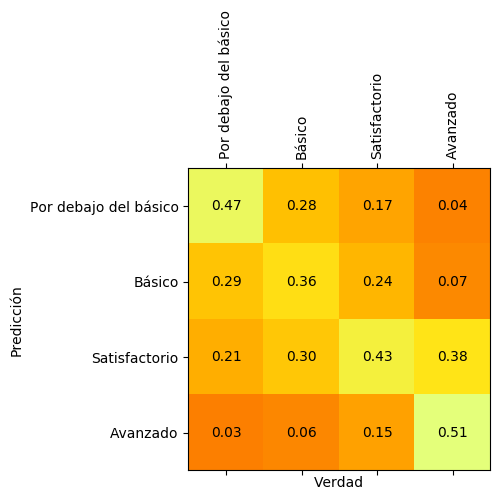

In [23]:
fig = plt.figure(dpi=100)
axes = fig.add_subplot(1, 1, 1)
color_map = plt.cm.get_cmap('Wistia')
reversed_color_map = color_map.reversed()
axes.matshow(cm_relative, cmap=reversed_color_map)
for (i, j), z in np.ndenumerate(cm_relative):
    axes.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
#axes.set_xticklabels(list(y_lb.classes_))
axes.set_yticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
axes.set_xticklabels(['']+["Por debajo del básico", "Básico", "Satisfactorio", "Avanzado"])
plt.ylabel("Predicción")
plt.xlabel("Verdad")
plt.xticks(rotation=90)
plt.savefig("plots/lightgbm_confusion_matrix_%s.png" % CATEGORIA_NIVEL)

In [20]:
import shap
shap_values = shap.TreeExplainer(bst).shap_values(X_valid)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [28]:
y_lb.classes_

array(['avanzado', 'basico', 'por_debajo_del_basico', 'satisfactorio'],
      dtype=object)

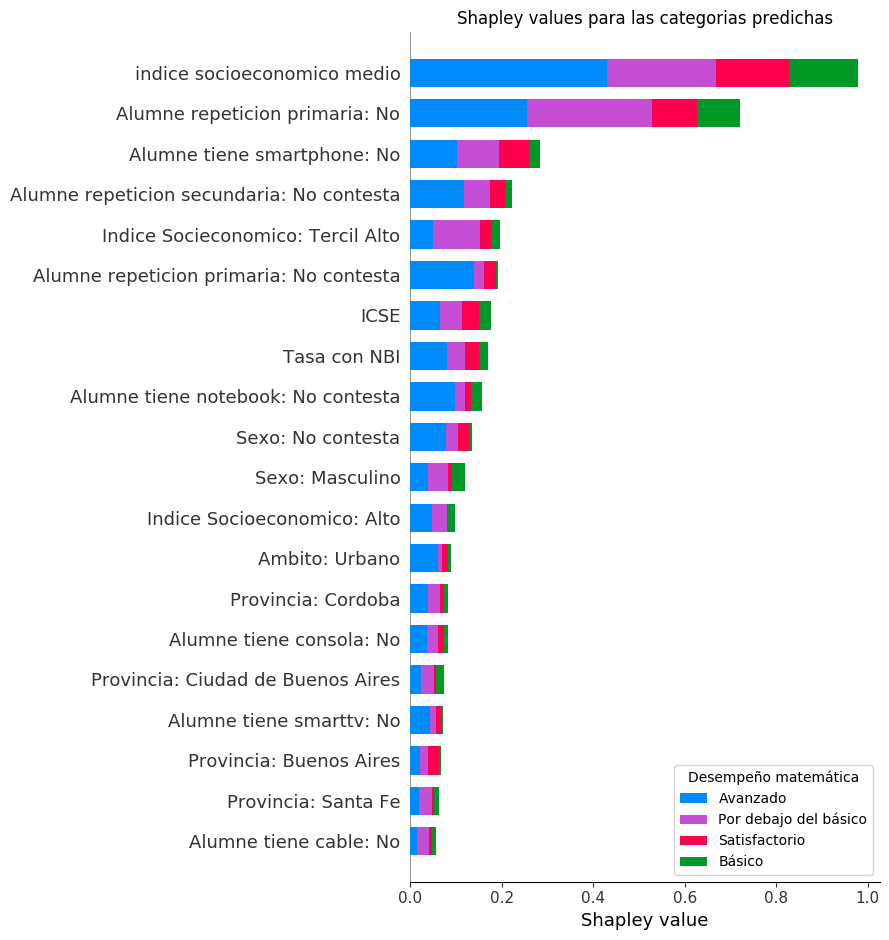

In [56]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.figure(dpi=100)
shap.summary_plot(shap_values, X_valid, show=False)
leg = plt.gca().legend()
y_ticks = list(plt.gca().get_yticklabels())
for i in range(len(y_ticks)):
    y_ticks[i].set_text(y_ticks[i].get_text().replace("__", ": ").replace("_", " "))
plt.gca().set_yticklabels(y_ticks)
plt.gcf().set_size_inches(9,9.5)
leg.set_title("Desempeño %s" % CATEGORIA_LABEL)
LABELS = {"Class 0": "Avanzado", "Class 1": "Básico", "Class 2": "Por debajo del básico", "Class 3": "Satisfactorio"}
for t in leg.texts: t.set_text(LABELS[t.get_text()])
plt.title("Shapley values para las categorias predichas")
plt.xlabel("Shapley value")
plt.savefig("plots/lightgbm_shapley_%s.png" % CATEGORIA_NIVEL)